In [1]:
cd /content/drive/My Drive/Colab Notebooks/PSPNet_brain_mri

/content/drive/My Drive/Colab Notebooks/PSPNet_brain_mri


In [2]:
import os 
import math
import time
import pandas as pd
import numpy as np
import cv2

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from utils.dataloader import make_datapath_list, DataTransform, BrainDataset

In [4]:
rootpath = os.path.abspath("")
makepath = make_datapath_list(rootpath)
train_img_list, train_anno_list = makepath.get_list("train")
val_img_list, val_anno_list = makepath.get_list("val")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


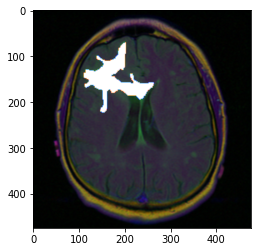

In [5]:
train_dataset = BrainDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(input_size=475))

val_dataset = BrainDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(input_size=475))

i = 6
img = train_dataset.__getitem__(i)[0]
img = img.clone().numpy()
img = img.transpose((1,2,0))
anno = train_dataset.__getitem__(i)[1]
anno = anno.clone().numpy()*255
anno = cv2.cvtColor(anno, cv2.COLOR_BAYER_BG2BGR)
anno = np.asarray(anno, np.float64)
blended_img = cv2.addWeighted(src1=img, alpha=0.8, src2=anno, beta=0.2, gamma=0)
plt.imshow(blended_img)
plt.show()

In [6]:
batch_size = 4
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [8]:
from utils.pspnet import PSPNet

# net = PSPNet(n_classes=2)

net = PSPNet(n_classes = 150)
net
state_dict = torch.load("./weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

n_classes = 2
net.decode_feature.classification = nn.Conv2d(in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)
net.aux.classification = nn.Conv2d(in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

def weights_init(m):
  #nn.Conv2dであれば適用
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [9]:
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 4755]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)

In [10]:
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [11]:
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    train_loss_list = []
    val_loss_list = []
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                net.eval()   # モデルを検証モードに
                print('-------------')
                print('（val）')

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device, dtype=torch.float)
                anno_class_imges = anno_class_imges.to(device, dtype=torch.float)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier
      
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        #lossの可視化のリスト
        train_loss_list.append(epoch_train_loss/num_train_imgs)
        val_loss_list.append(epoch_val_loss/num_val_imgs)
        if ((epoch+1) % 5 == 0):
          torch.save(net.state_dict(), 'weights/pspnet50_' + str(epoch+1) + '.pth')
        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/pspnet50_' +
               str(epoch+1) + '.pth')
    return train_loss_list, val_loss_list

In [12]:
num_epochs = 15
train_loss_list, val_loss_list = train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/15
-------------
（train）


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Iteration 10 || Loss: 0.0469 || 10iter: 75.1737 sec.
Iteration 20 || Loss: 0.0250 || 10iter: 57.6751 sec.
Iteration 30 || Loss: 0.0020 || 10iter: 58.7918 sec.
Iteration 40 || Loss: 0.0376 || 10iter: 59.9242 sec.
Iteration 50 || Loss: 0.0818 || 10iter: 62.5361 sec.
Iteration 60 || Loss: 0.0268 || 10iter: 65.7610 sec.
Iteration 70 || Loss: 0.0067 || 10iter: 70.8695 sec.
Iteration 80 || Loss: 0.0103 || 10iter: 63.0008 sec.
Iteration 90 || Loss: 0.0305 || 10iter: 57.4276 sec.
Iteration 100 || Loss: 0.0147 || 10iter: 57.3714 sec.
Iteration 110 || Loss: 0.0038 || 10iter: 63.1395 sec.
Iteration 120 || Loss: 0.0120 || 10iter: 59.6355 sec.
Iteration 130 || Loss: 0.0113 || 10iter: 57.5823 sec.
Iteration 140 || Loss: 0.0054 || 10iter: 68.7188 sec.
Iteration 150 || Loss: 0.0051 || 10iter: 59.4004 sec.
Iteration 160 || Loss: 0.0142 || 10iter: 65.0406 sec.
Iteration 170 || Loss: 0.0066 || 10iter: 58.0373 sec.
Iteration 180 || Loss: 0.0017 || 10iter: 59.9975 sec.
Iteration 190 || Loss: 0.0036 || 10it

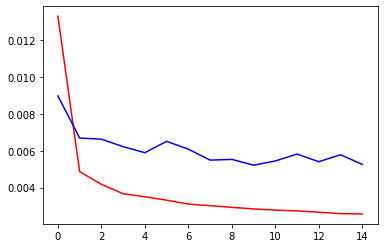

In [13]:
plt.plot(train_loss_list, color='red')
plt.plot(val_loss_list, color='blue')
plt.show()